In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
import warnings, os
from tqdm import tqdm
import seaborn as sns
import cvxpy as cp
import os
import torch 
import random
import sys
import os
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import ProgressBarCallback
import optuna

### Import functions from .py files

In [2]:
scripts_path = os.path.abspath(os.path.join("..", "scripts"))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
    
from datacollection import *
from EPFmodels import *
from helpers import *
from BatteryEnv import * 
from DQN import *
from PPOd import *
from PPOc import *
from SAC import *

SEED = 2025
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)


## Data Collection and Visualization

### Price and Generation data:

,mean,std,min,25%,50%,75%,max
Price,138.28,113.14,-500.00,75.88,106.18,174.70,872.96
Solar,58.61,92.30,0.00,0.00,2.00,90.00,428.00
Wind Onshore,866.05,677.97,5.75,281.75,670.50,1358.25,2545.50
Wind Offshore,1320.14,1072.82,0.00,376.00,1071.75,2109.50,4343.00
Load Forecast (MW),11068.13,2244.72,478.75,9955.19,11119.75,12421.75,21256.75
Actual Aggregated,8650.90,2297.95,2571.25,6971.25,8411.75,10098.25,16632.75
temperature_2m,11.56,6.39,-7.40,7.00,11.30,16.20,34.60
cloudcover,68.82,38.91,0.00,31.00,97.00,100.00,100.00
sunshine_duration,1086.36,1597.11,0.00,0.00,0.00,3600.00,3600.00


ADF Test Statistic: -6.137140557205142
p-value: 8.13547481720705e-08
Critical Values: {'1%': -3.430599102593299, '5%': -2.8616500960359854, '10%': -2.5668286008605627}
The series is likely stationary (reject H0).


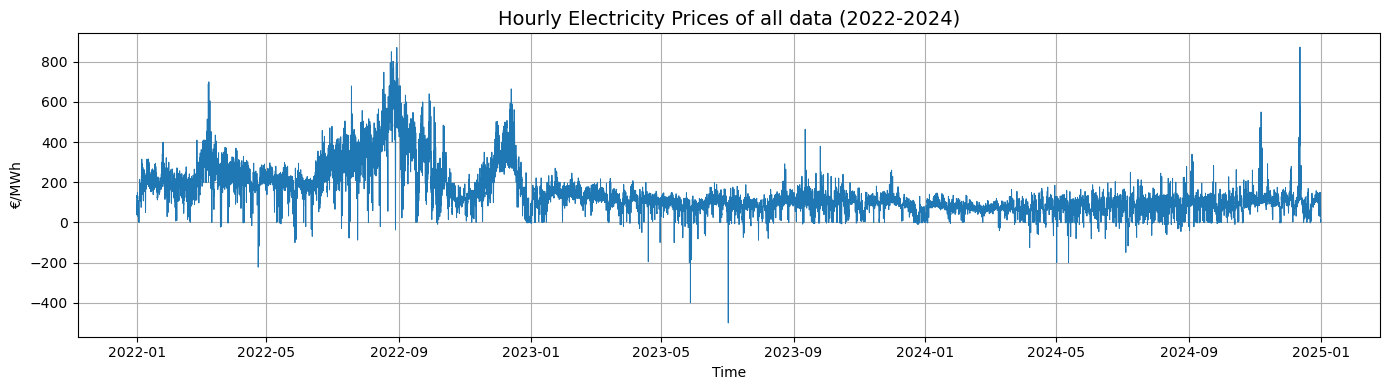

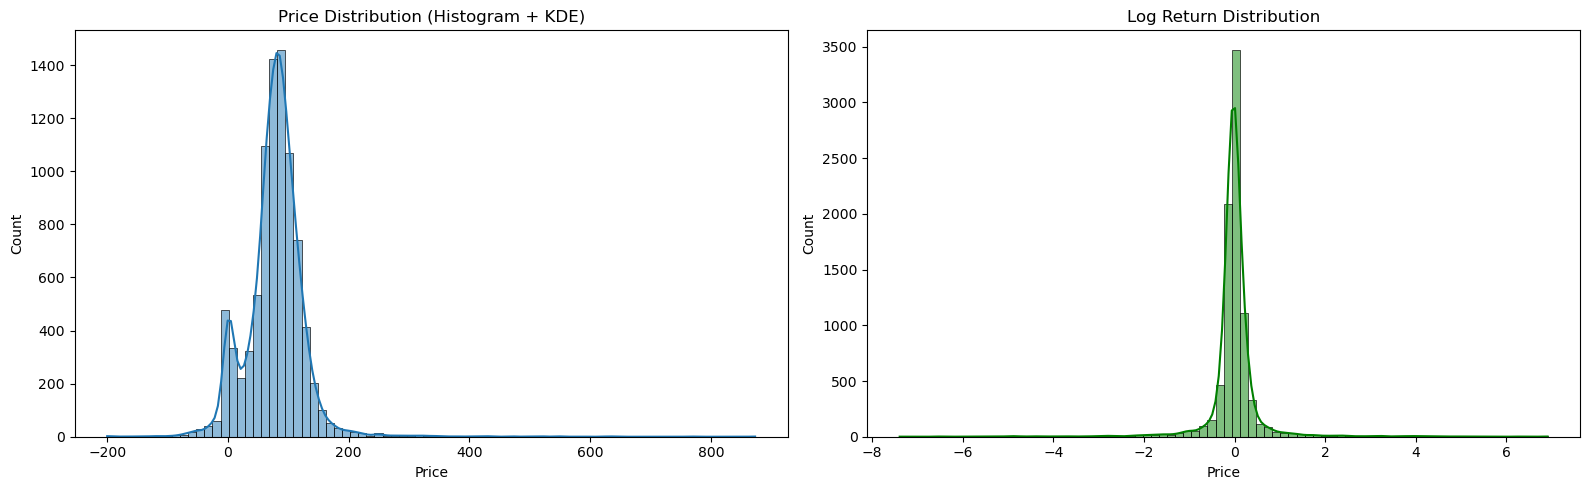

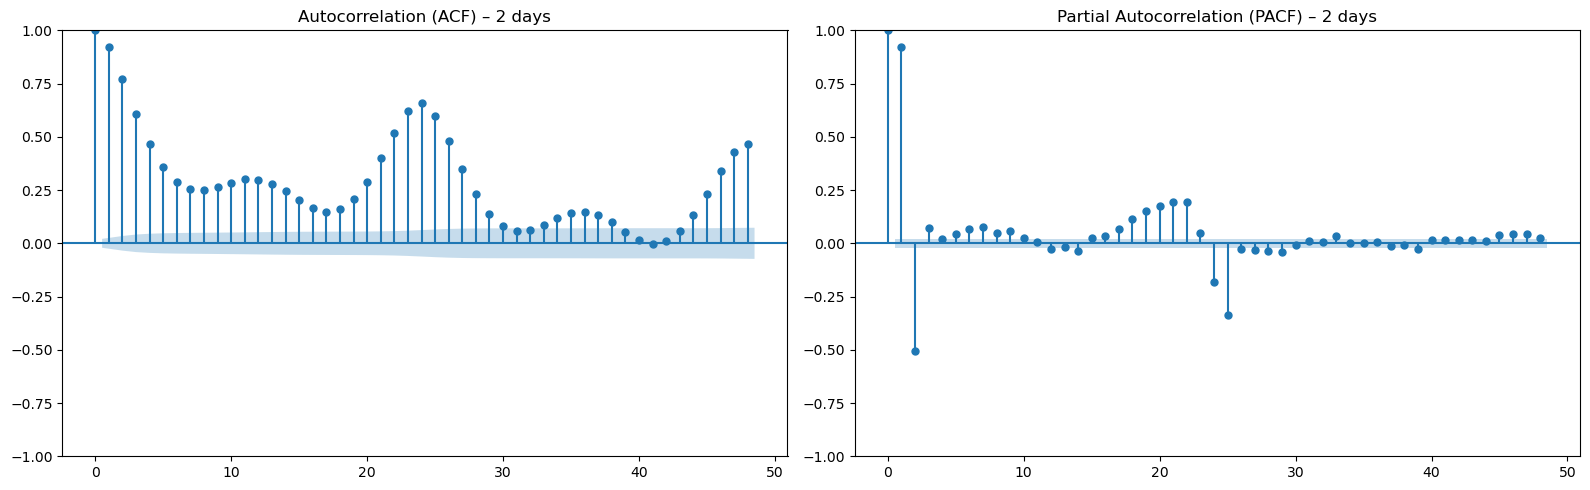

In [3]:
file_path = "../data/merged_energy_weather_2022_2024.csv"
price, price_scaled, exog, exog_raw, price_kWh = preprocess_energy_data(file_path)
get_descriptive(price, exog_raw)
pricevisualization(price)

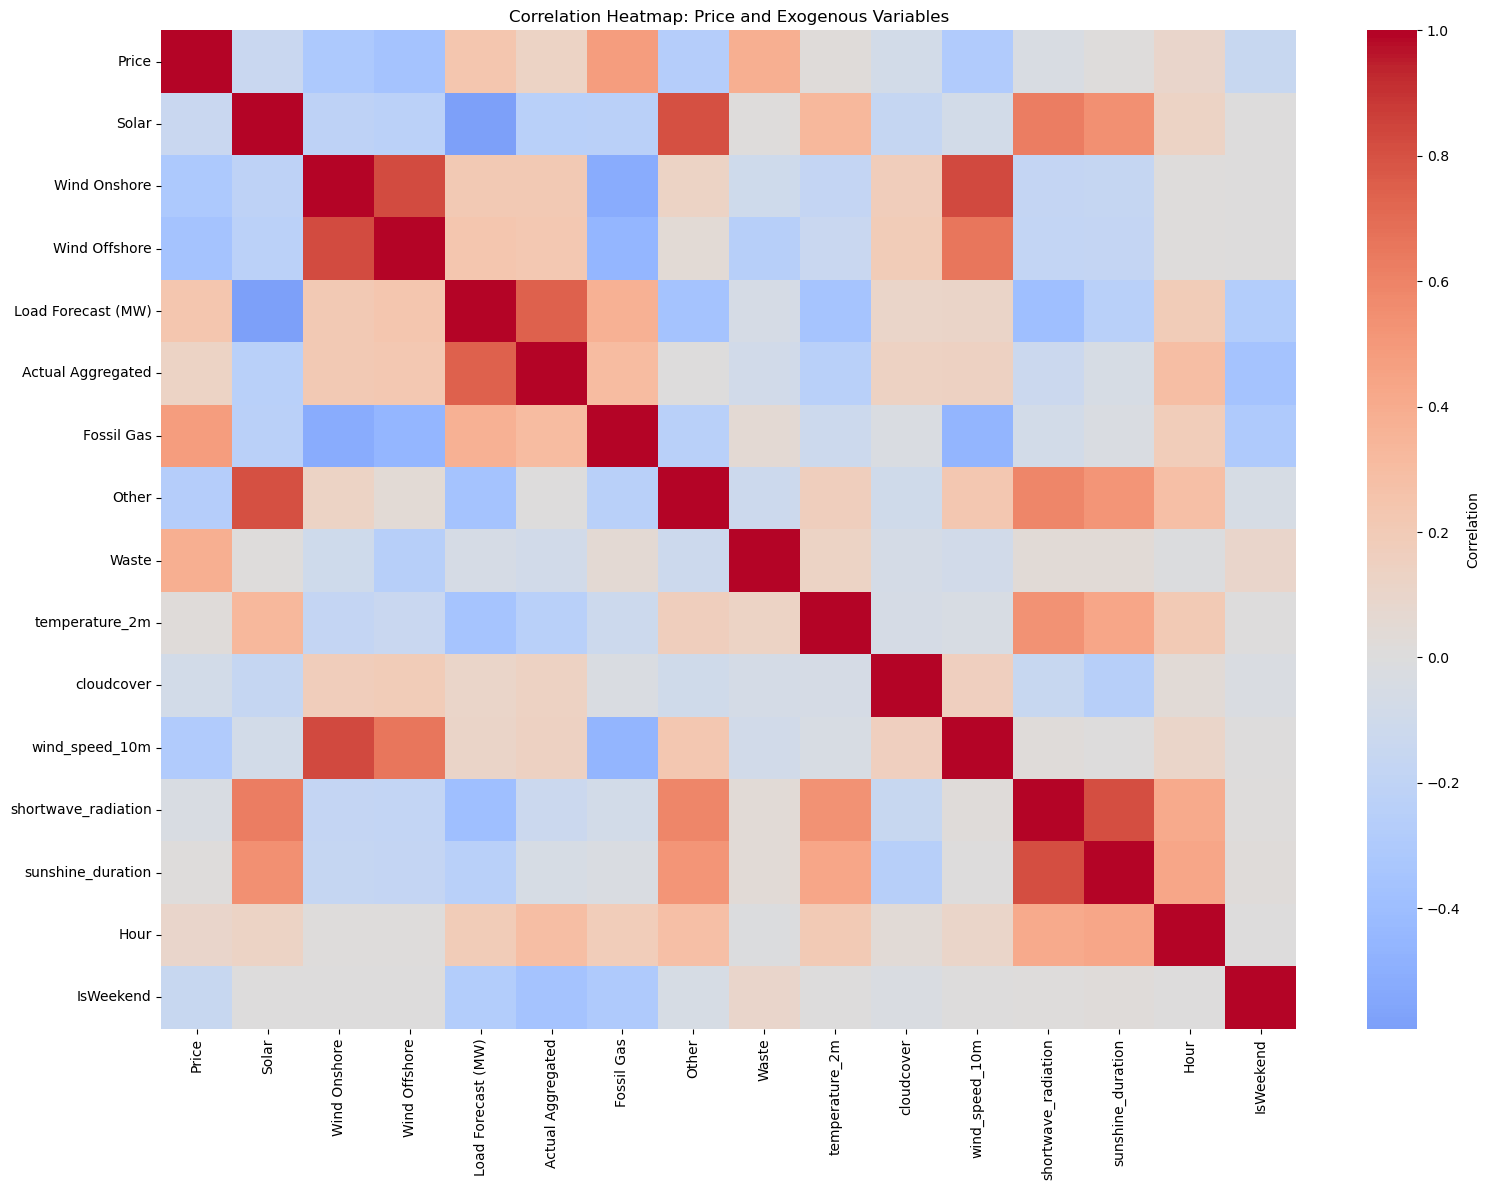

Correlation of each variable with Price:
Price                  1.000000
Fossil Gas             0.479829
Waste                  0.384778
Load Forecast (MW)     0.235831
Actual Aggregated      0.128870
Hour                   0.101942
temperature_2m         0.017717
sunshine_duration      0.013173
shortwave_radiation   -0.035356
cloudcover            -0.075977
Solar                 -0.138636
IsWeekend             -0.144607
Other                 -0.272758
wind_speed_10m        -0.291772
Wind Onshore          -0.315622
Wind Offshore         -0.361941
Name: Price, dtype: float64


In [4]:
correlation_analysis(price, exog)

### Simulated Firm-Specific Demand and Generation data

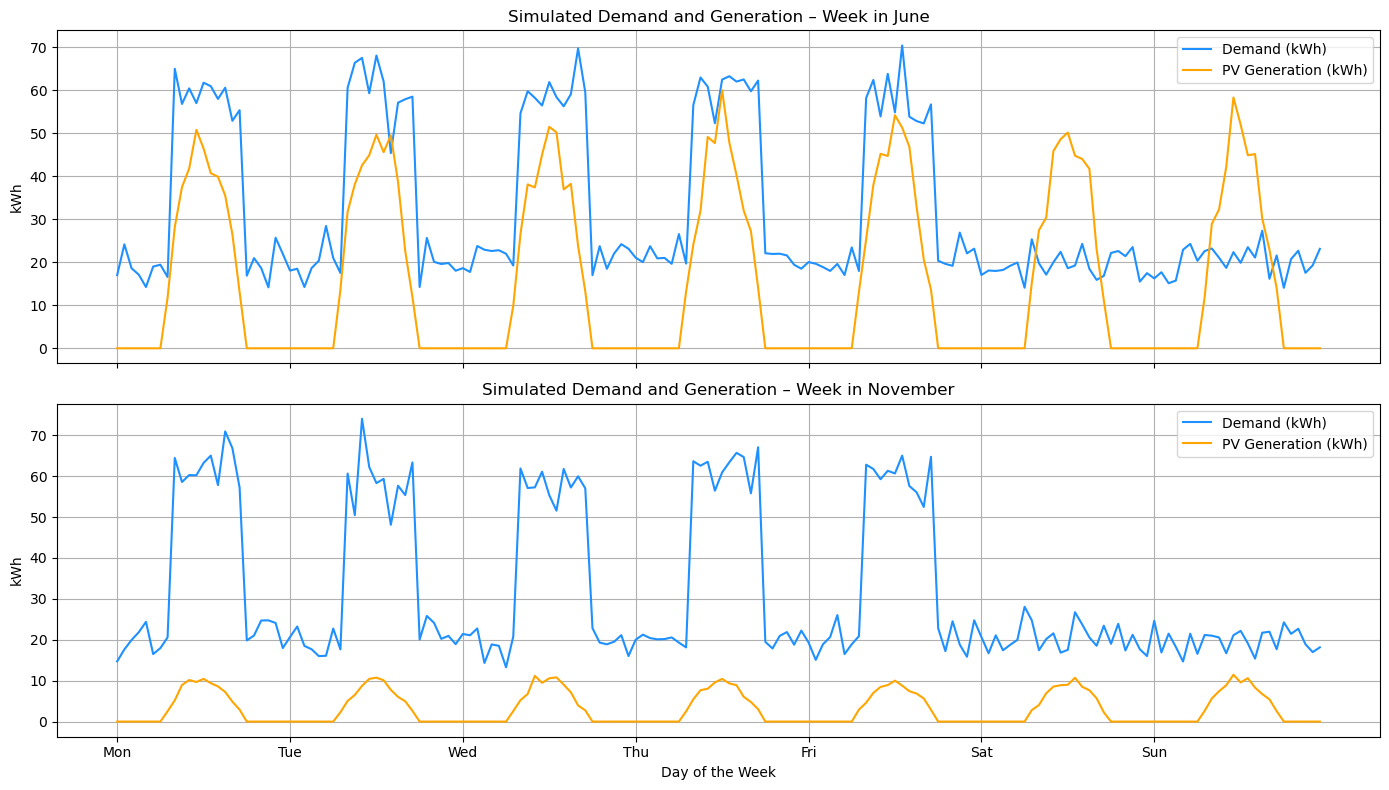

In [5]:
simdata = generate_simdata(price)
visualize_simdata(simdata)

## Energy Price Forecasting

In [6]:
########## Run forecasting models ########## (+/- 3,5 mins)

# Max window = 1040 days
window = 1040
# AR_rmse , AR_mae, AR_t, AR_pred = rolling_forecast_AR(price, horizon=24, days=window)
# ARX_rmse, ARX_mae, ARX_t, ARX_pred = rolling_forecast_ARX(price, exog, horizon=24, days=window)
# LEAR_rmse, LEAR_mae, LEAR_t, LEAR_pred, true_prices, model_used_per_day = rolling_forecast_LEAR_with_AR_fallback(price, exog, horizon=24, days=window)

# # EPFperformance(AR_t, AR_rmse, AR_mae, ARX_t, ARX_rmse, ARX_mae, LEAR_t, LEAR_rmse, LEAR_mae)
# EPFperformance(AR_t, AR_rmse, AR_mae, ARX_t, ARX_rmse, ARX_mae, LEAR_t, LEAR_rmse, LEAR_mae, LEAR_pred, true_prices)


############ Save forecasts ########

# AR_pred.to_csv("AR_predictions_30_6.csv")
# ARX_pred.to_csv("ARX_predictions_30_6.csv")
# LEAR_pred.to_csv("LEAR_predictions_30_6.csv")

In [7]:
########## Or Load saved forecasts from data folder ########## 

AR_forecasts, _, LEAR_forecasts, perfect_foresight_forecasts = import_EPFforecasts("../data/AR_predictions_30_6.csv", "../data/LEAR_predictions_30_6.csv", price)

## Battery Control Strategies

In [8]:
traindata, testdata = align_and_split_data(price, simdata, AR_forecasts, LEAR_forecasts, perfect_foresight_forecasts, exog,
                                           train_end="2023-12-31 23:00:00", test_start="2024-01-01 00:00:00", tz="Europe/Amsterdam")

#### Hyperparameter tuning

In [ ]:
# Hypertuning function in helpers.py

# # Hyperparameter tuning for DQN
# study_DQN = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_DQN.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="DQN"), n_trials=30)
# best_DQN = study_DQN.best_trial

# # Hyperparameter tuning for PPOd
# study_PPOd = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_PPOd.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="PPOd"), n_trials=30)
# best_PPOd = study_PPOd.best_trial

# # Hyperparameter tuning for PPOc
# study_PPOc = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study_PPOc.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="PPOc"), n_trials=30)
# best_PPOc = study_PPOc.best_trial

# Hyperparameter tuning for SAC
study_SAC = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study_SAC.optimize(lambda trial: hypertuning(trial, traindata, testdata, simdata, algo="SAC"), n_trials=30)
best_SAC = study_SAC.best_trial

# print("\nBest hyperparameters found for DQN:")
# for k, v in best_DQN.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_DQN.value:.2f}%")
# print("")
# print("\nBest hyperparameters found for PPOd:")
# for k, v in best_PPOd.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_PPOd.value:.2f}%")
# print("")
# print("\nBest hyperparameters found for PPOc:")
# for k, v in best_PPOc.params.items():
#     print(f"  {k}: {v}")
# print(f"\nBest savings percentage: {best_PPOc.value:.2f}%")
# print("")
print("\nBest hyperparameters found for SAC:")
for k, v in best_SAC.params.items():
    print(f"  {k}: {v}")
print(f"\nBest savings percentage: {best_SAC.value:.2f}%")

[I 2025-07-07 15:13:39,625] A new study created in memory with name: no-name-3284d9d2-e4b8-40e0-855f-bb08d14765f6


Training SAC using LEAR forecasts and sell_price_ratio=1.0


Output()

#### DQN for AR, LEAR, perfect foresight, sellratio 1.0
##### Optimized hyperparameters for DQN:  
 FOR LEAR  
  learning_rate: 0.0004457993980051172  
  batch_size: 128  
  gamma: 0.9142604076178287  
  timesteps: 116176  

In [10]:
# def train_and_test_dqn(
#     train, test, simdata, forecast_type, sell_price_ratio=1.0, SEED=2025,
#     model_save_path=None, load_existing_model=False, model_load_path=None,
#     timesteps=50000, learning_rate=5e-4, batch_size=64, gamma=0.99
# ):

learning_rate_DQN = 0.0004457993980051172  
batch_size_DQN = 128  
gamma_DQN = 0.9142604076178287  
timesteps_DQN = 116176 

# Load DQN models
results_dqn_ar = train_and_test_dqn(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="AR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/dqn_AR.zip",
    timesteps=timesteps_DQN,
    learning_rate=learning_rate_DQN,
    batch_size=batch_size_DQN,
    gamma=gamma_DQN,
)
print("")
results_dqn_lear = train_and_test_dqn(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="LEAR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/dqn_LEAR.zip",
    timesteps=timesteps_DQN,
    learning_rate=learning_rate_DQN,
    batch_size=batch_size_DQN,
    gamma=gamma_DQN,
)
print("")
results_dqn_perfect = train_and_test_dqn(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="perfect",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/dqn_perfect.zip",
    timesteps=timesteps_DQN,
    learning_rate=learning_rate_DQN,
    batch_size=batch_size_DQN,
    gamma=gamma_DQN,
)

Loading existing model from ../models/dqn_AR.zip
The model is now Testing DQN using AR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €14,008.52
✅ Savings from Battery:    €4,759.66
📉 Savings Percentage:       25.36%

Loading existing model from ../models/dqn_LEAR.zip
The model is now Testing DQN using LEAR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €13,158.80
✅ Savings from Battery:    €5,609.39
📉 Savings Percentage:       29.89%

Loading existing model from ../models/dqn_perfect.zip
The model is now Testing DQN using perfect forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €13,255.75
✅ Savings from Battery:    €5,512.43
📉 Savings Percentage:       29.37%


### PPO discrete for AR, LEAR, perfect foresight, sellratio 1.0
#### Optimized hyperparameters
FOR LEAR  
learning_rate: 0.00021391945303587435  
batch_size: 128  
gamma: 0.9037833289757886  
gae_lambda: 0.9023175195534727  
n_steps: 594  
timesteps: 1400000  

In [11]:
# def train_and_test_PPOd(
#     train, test, simdata, forecast_type, sell_price_ratio=1.0, SEED=2025,
#     model_save_path=None, load_existing_model=False, model_load_path=None,
#     n_envs=1, n_stack=4,
#     learning_rate=3e-4, batch_size=256, gamma=0.99, gae_lambda=0.97, n_steps=336, total_timesteps=300_000
# ):

learning_rate_PPOd = 0.00021391945303587435 
batch_size_PPOd = 128
gamma_PPOd = 0.9037833289757886
gae_lambda_PPOd = 0.9023175195534727
n_steps_PPOd = 594
timesteps_PPOd = 1400000

# # Load PPOd models
results_PPOd_ar = train_and_test_PPOd(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="AR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_d_AR.zip",
    learning_rate=learning_rate_PPOd,
    batch_size=batch_size_PPOd,
    gamma=gamma_PPOd,
    gae_lambda=gae_lambda_PPOd,
    n_steps=n_steps_PPOd,
    total_timesteps=timesteps_PPOd,
)
print("")
results_PPOd_lear = train_and_test_PPOd(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="LEAR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_d_LEAR.zip",
    learning_rate=learning_rate_PPOd,
    batch_size=batch_size_PPOd,
    gamma=gamma_PPOd,
    gae_lambda=gae_lambda_PPOd,
    n_steps=n_steps_PPOd,
    total_timesteps=timesteps_PPOd,
)
print("")
results_PPOd_perfect = train_and_test_PPOd(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="perfect",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_d_perfect.zip",
    learning_rate=learning_rate_PPOd,
    batch_size=batch_size_PPOd,
    gamma=gamma_PPOd,
    gae_lambda=gae_lambda_PPOd,
    n_steps=n_steps_PPOd,
    total_timesteps=timesteps_PPOd,
)

Loading existing PPO model from ../models/ppo_d_AR.zip
Testing PPO using AR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €13,215.01
✅ Savings from Battery:    €5,553.17
📉 Savings Percentage:       29.59%

Loading existing PPO model from ../models/ppo_d_LEAR.zip
Testing PPO using LEAR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €10,998.14
✅ Savings from Battery:    €7,770.05
📉 Savings Percentage:       41.40%

Loading existing PPO model from ../models/ppo_d_perfect.zip
Testing PPO using perfect forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €11,550.42
✅ Savings from Battery:    €7,217.76
📉 Savings Percentage:       38.46%


### PPO continuous for AR, LEAR, perfect foresight, sellratio = 1.0
#### Optimized hyperparameters
learning_rate: 0.00016734174724349077  
batch_size: 256  
gamma: 0.9384084377398001  
gae_lambda: 0.9244330236577202  
n_steps: 534  
timesteps: 1800000  

In [12]:
learning_rate_PPOc = 0.00016734174724349077
batch_size_PPOc = 256
gamma_PPOc = 0.9384084377398001
gae_lambda_PPOc = 0.9244330236577202
n_steps_PPOc = 534
timesteps_PPOc = 1800000

# Load PPOc models
results_PPOc_ar = train_and_test_PPOc(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="AR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_c_AR.zip",
    learning_rate=learning_rate_PPOc,
    batch_size=batch_size_PPOc,
    gamma=gamma_PPOc,
    gae_lambda=gae_lambda_PPOc,
    n_steps=n_steps_PPOc,
    total_timesteps=timesteps_PPOc,
)
print("")
results_PPOc_lear = train_and_test_PPOc(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="LEAR",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_c_LEAR.zip",
    learning_rate=learning_rate_PPOc,
    batch_size=batch_size_PPOc,
    gamma=gamma_PPOc,
    gae_lambda=gae_lambda_PPOc,
    n_steps=n_steps_PPOc,
    total_timesteps=timesteps_PPOc,
)
print("")
results_PPOc_perfect = train_and_test_PPOc(
    train=traindata,
    test=testdata,
    simdata=simdata,
    forecast_type="perfect",
    sell_price_ratio=1.0,
    load_existing_model=True,
    model_load_path="../models/ppo_c_perfect.zip",
    learning_rate=learning_rate_PPOc,
    batch_size=batch_size_PPOc,
    gamma=gamma_PPOc,
    gae_lambda=gae_lambda_PPOc,
    n_steps=n_steps_PPOc,
    total_timesteps=timesteps_PPOc,
)

Loading existing PPO continuous model from ../models/ppo_c_AR.zip
Testing PPO (continuous) using AR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €12,897.22
✅ Savings from Battery:    €5,870.97
📉 Savings Percentage:       31.28%

Loading existing PPO continuous model from ../models/ppo_c_LEAR.zip
Testing PPO (continuous) using LEAR forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €11,255.38
✅ Savings from Battery:    €7,512.80
📉 Savings Percentage:       40.03%

Loading existing PPO continuous model from ../models/ppo_c_perfect.zip
Testing PPO (continuous) using perfect forecasts and sell price ratio: 1.0
💰 No Battery Cost:         €18,768.18
🔋 With Battery Cost:       €10,860.63
✅ Savings from Battery:    €7,907.55
📉 Savings Percentage:       42.13%


### SAC for AR, LEAR, perfect foresight, sellratio = 1.0

'learning_rate': 0.0008482589990647749,  
'batch_size': 128, 'gamma': 0.9082708279501825,  
'tau': 0.00042448827150402146,  
'timesteps': 2000000 

In [13]:
# # def train_and_test_SAC(
# #     train, test, simdata, forecast_type, sell_price_ratio=1.0, SEED=2025,
# #     model_save_path=None, load_existing_model=False, model_load_path=None,
# #     n_envs=1, n_stack=4,
# #     learning_rate=3e-4, batch_size=256, gamma=0.99, tau=0.005, ent_coef="auto", total_timesteps=300_000
# # ):

# learning_rate_SAC = 0.0009970009726455898
# batch_size_SAC = 256
# gamma_SAC = 0.9569744066451857
# tau_SAC = 0.97
# timesteps_SAC = 100000

# # Load SAC models
# results_SAC_ar = train_and_test_SAC(
#     train=traindata,
#     test=testdata,
#     simdata=simdata,
#     forecast_type="AR",
#     sell_price_ratio=1.0,
#     load_existing_model=False,
#     # model_save_path="../models/sac_AR.zip",
#     learning_rate=learning_rate_SAC,
#     batch_size=batch_size_SAC,
#     gamma=gamma_SAC,
#     tau=tau_SAC,
#     total_timesteps=timesteps_SAC,
# )

#### Cycle and Grid use analysis

In [17]:
df_rl_result_2024 = results_PPOc_perfect[0]  # The DataFrame with SOC
soc = df_rl_result_2024["soc_kWh"].dropna().values
soc_diff = np.abs(np.diff(soc))
battery_capacity = 200.0  # kWh
total_cycles = soc_diff.sum() / (2 * battery_capacity)
print(f"Estimated total battery cycles: {total_cycles:.2f}")

Estimated total battery cycles: 659.09
